# Load libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#settings
params = {'legend.fontsize': 9,
          'figure.figsize': (15, 5),
         'axes.labelsize': 10,
         'axes.titlesize':11,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'axes.grid': True,
         'axes.grid.which': 'both',
         'grid.linestyle': '--',
         'grid.color': 'silver',
         'grid.alpha': 0.5,
         'lines.linewidth': 1,
         'lines.markersize': 4

         }

plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 150
blue = '#005AB5'
red = '#DC3220'

In [3]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):

    '''
    Calculate the mean absolute percentage error (MAPE)
    '''
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100




In [4]:
df = pd.read_csv('/content/02_TEU_month.csv', index_col=0)

df.index = pd.to_datetime(df.index)

df.head()

,TEU
Date,
2010-01-01,493.136
2010-02-01,447.869
2010-03-01,532.599
2010-04-01,485.357
2010-05-01,596.628


In [5]:
df.shape

(180, 1)

# Load tensorflow libraries

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  #classe utilizada para criar o modelo sequencial utilizando o keras
from tensorflow.keras.layers import Dense  # Classe utilizada para criar as camadas que são completamente conectadas
from tensorflow.keras.layers import LSTM  # Classe para a rede recorrente utilizando Long Shor Term Memory
from tensorflow.keras.layers import Dropout # Classe utilizada para a camada de dropout (utilizada para evitar o overfiting)
import keras
import os
import random
from sklearn.preprocessing import MinMaxScaler

# Model Build

In [ ]:
def preprocessing(data, month_lag, test_size):

    '''
    perform the data split, normalize and prepare the data for the model.
    It also create the lags of the time series to be used as features.

    y_t = y_t-1 + y_t-2 + ... + y_t-n
    '''

    size = -test_size

    Train, Test = data[:size], data[size:]

    X_train, X_test = data[:size], data[size-month_lag:]

    scaler = MinMaxScaler((0,1))

    X_train_scale = scaler.fit_transform(X_train.values.reshape(-1, 1))

    X_test_scale = scaler.transform(X_test.values.reshape(-1, 1))



    #Como as redes recorrentes utilizam dados no tempo T e valores passados (T-n), a entrada da rede deve conter os
    #valores presentes e os (T-n). Assim, é necessário realizar uma modificação nos dados
    features_set = []
    labels = []
    for i in range(month_lag, len(X_train_scale)):
        features_set.append(X_train_scale[i-month_lag:i, 0])
        labels.append(X_train_scale[i, 0])

    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    labels = np.reshape(labels, (labels.shape[0], 1))
    print(features_set.shape)
    print(labels.shape)

    test_features = []
    for i in range(month_lag, len(X_test_scale)):
        test_features.append(X_test_scale[i-month_lag:i, 0])

    #preparando os dados como entrada para o modelo de previsão
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    test_labels = np.array(X_test_scale[month_lag:])

    return features_set, labels, test_features, test_labels, scaler

In [8]:
# Set seeds for reproducibility
seed = 42
# Enable deterministic operations (TensorFlow 2.9+)
tf.config.experimental.enable_op_determinism()
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Set environment variables for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


# Disable GPU (optional, for testing)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [9]:
batch_size = int(64)
Max_neurons = int(512)
epochs = int(300)

In [10]:
def LSTM_model(batch_size, Max_neurons, X, y):

    '''
    Create and compile the LSTM model.
    '''


    tf.keras.backend.clear_session()

    ################
    model = Sequential()
    model.add(LSTM(units = Max_neurons, return_sequences=True, input_shape=(X.shape[1], 1), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = Max_neurons, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))

    # model.add(LSTM(units = Max_neurons, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.2))

    model.add(LSTM(units = Max_neurons))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=10e-4), loss = 'mse', metrics=['mae'])
    ################
    return model

In [11]:
def scoring(X_true, y_true, model):

    '''
    Evaluate the performance of the model using MAPE, RMSE.
    '''
    pred = model.predict(X_true)
    pred = scaler.inverse_transform(pred).ravel()

    y_true = scaler.inverse_transform(y_true).ravel()

    mape = mean_absolute_percentage_error(y_true, pred)
    rmse = sqrt( mean_squared_error(y_true, pred))


    return mape, rmse

# Loop Serach

In [12]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping

# Set parameters
test_size = 24 #months

batch_size = [8, 16]
Max_neurons = [50, 100, 150]
epochs = [100]
lag_months = 3

# Define K-fold cross-validation with 5 splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size = test_size)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


table_results = []
i = 0

# Convert lag_months to a list if it's a single value
if not isinstance(lag_months, list):
    lag_months = [lag_months]

for n in lag_months:
    features_set, labels, test_features, test_labels, scaler = preprocessing(df['TEU'], n, test_size)

    for bs in batch_size:
        for units in Max_neurons:
            for e in epochs:
                i += 1
                print(f'i: {i} - lags: {n} - bs: {bs} - units:{units} - epoch: {e}')

                # Initialize lists to store cross-validation scores
                cv_train_scores = []
                cv_val_scores = []

                # Create a fresh model for each hyperparameter combination
                base_model = LSTM_model(bs, units, features_set, labels)

                # Perform time series cross-validation
                for train_idx, val_idx in tscv.split(features_set):
                    # Split data into training and validation sets
                    X_train, X_val = features_set[train_idx], features_set[val_idx]
                    y_train, y_val = labels[train_idx], labels[val_idx]

                    # Clone the model for this CV fold to ensure fresh training
                    model = tf.keras.models.clone_model(base_model)
                    model.compile(optimizer=keras.optimizers.Adam(learning_rate=10e-4), loss='mse', metrics=['mae'])

                    # Train with early stopping and validation data
                    history = model.fit(
                        X_train, y_train,
                        epochs=e,
                        batch_size=bs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0,
                        shuffle=False
                    )

                    # Calculate scores on training and validation sets
                    train_score = scoring(X_train, y_train, model)
                    val_score = scoring(X_val, y_val, model)

                    cv_train_scores.append(train_score)
                    cv_val_scores.append(val_score)

                # Calculate average metrics across all CV folds
                avg_train = np.mean(cv_train_scores, axis=0)
                avg_val = np.mean(cv_val_scores, axis=0)

                # Train a final model on the entire training set with the current hyperparameters
                final_model = LSTM_model(bs, units, features_set, labels)
                final_model.fit(
                    features_set, labels,
                    epochs=e,
                    batch_size=bs,
                    validation_split=0.2,  # Use 20% for validation
                    callbacks=[early_stopping],
                    verbose=0,
                    shuffle=False
                )

                # Get test scores using the final model
                test_score = scoring(test_features, test_labels, final_model)

                # Store results
                table_results.append([
                    n, bs, units,
                    avg_train[0], avg_train[1],  # Training metrics (averaged over CV)
                    avg_val[0], avg_val[1],       # Validation metrics (averaged over CV)
                    test_score[0], test_score[1],  # Test metrics (final model)
                ])
                mean = (avg_train[0] + avg_val[0])/2


                # Update best model if this configuration performs better
                if i == 1:
                    best_model = final_model
                    best_score = mean
                else:
                    if mean < best_score:
                        best_model = final_model
                        best_score = mean

model = best_model
model.save('best_model.h5')

table_results = pd.DataFrame(table_results)
table_results.columns = ['Lags', 'Batch Size', 'Units',
                        'train_MAPE',  'train_RMSE',
                        'val_MAPE', 'val_RMSE',
                        'test_MAPE', 'test_RMSE']
table_results = table_results.sort_values('train_MAPE').reset_index(drop=True)

table_results

(153, 3, 1)
(153, 1)
i: 1 - lags: 3 - bs: 8 - units:50 - epoch: 100
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
i: 2 - lags: 3 - bs: 8 - units:100 - epoch: 100
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 26.
3/3 ━━━━━━━━━━━━━━━━━━━

CPU times: user 5min 41s, sys: 27 s, total: 6min 8s
Wall time: 6min 16s


,Lags,Batch Size,Units,train_MAPE,train_RMSE,val_MAPE,val_RMSE,test_MAPE,test_RMSE
0,3,8,100,7.697180,61.708296,5.352519,53.535607,5.687173,67.383046
1,3,8,150,8.117639,64.861211,5.623432,55.804536,5.587095,65.977737
2,3,16,150,10.540005,82.009067,5.684484,57.211397,5.275162,70.943373
3,3,8,50,10.758232,84.945987,5.767062,56.656003,7.682203,97.327361
4,3,16,50,11.318780,89.307320,5.701140,58.126276,12.936882,159.886950
5,3,16,100,11.801994,91.849543,5.578526,56.108485,9.542895,117.794508


# Single Run

In [ ]:
batch_size = 8 #int( table_results['Batch Size'].values[0] )
Max_neurons = 100 #int( table_results['Units'].values[0] )
epochs = 100 #int( table_results['Epochs'].values[0] )
n = 3 #int( table_results['Lags'].values[0] )
test_size = test_size
print(batch_size)
print(Max_neurons)
print(epochs)
print(n)

8
100
100
3


In [ ]:
features_set, labels, test_features, test_labels, scaler = preprocessing(df['TEU'], n, test_size)

(153, 3, 1)
(153, 1)


In [ ]:
model = LSTM_model(batch_size, Max_neurons, features_set, labels)

In [ ]:
model.fit(
                    features_set, labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,  # Use 20% for validation
                    callbacks=[early_stopping],
                    verbose=0,
                    shuffle=False
                )

Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.


In [ ]:
scores = scoring(features_set, labels, model)
scores_test = scoring(test_features, test_labels, model)
print(scores)
print(scores_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(np.float64(6.17596952139495), 58.962763610955584)
(np.float64(5.310696101090881), 65.19697443831659)


# Plot Best Model Results

In [ ]:
print('-------BEST MODEL PARAMETERS-------')
print('Batch Size: {0:,.0f}'.format(table_results['Batch Size'].values[0]))
print('Units: {0:,.0f}'.format(table_results['Units'].values[0]))
print('Lags: {0:,.0f}'.format(table_results['Lags'].values[0]))

-------BEST MODEL PARAMETERS-------
Batch Size: 8
Units: 100
Lags: 3


In [ ]:
test_size = test_size
n = int( table_results['Lags'].values[0] )
features_set, labels, test_features, test_labels, scaler = preprocessing(df['TEU'], n, test_size)

model = best_model
pred = model.predict(features_set)
pred = scaler.inverse_transform(pred)

scores = scoring(features_set, labels, model )

train_mape = scores[0]
train_rmse = scores[1]


print('-----MODEL EVALUATION WITH THE PREVIOUS {:,.0F} MONTHS AS FEATURES-----'.format(n))
print(f'MAPE: {train_mape:.2f}%')
print(f'RMSE: {train_rmse:.2f}')



(153, 3, 1)
(153, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
-----MODEL EVALUATION WITH THE PREVIOUS 3 MONTHS AS FEATURES-----
MAPE: 6.03%
RMSE: 57.33


In [ ]:
test_size = test_size
labels_1d = scaler.inverse_transform(labels)

labels_1d = labels_1d.reshape(-1)
pred = pred.ravel()

Train = pd.DataFrame({'Train': labels_1d , 'Previsao': pred}, index=df[n:-test_size].index)

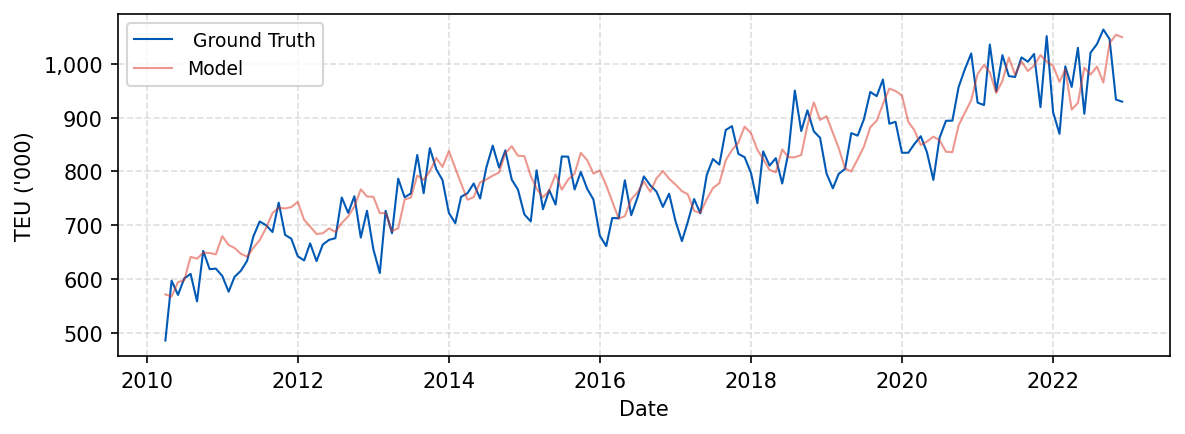

In [ ]:
plt.figure(figsize=(8,3))

plt.plot(Train.index, Train.Train, label=' Ground Truth', color= blue) # Adjust x-axis data
plt.plot(Train.index, Train.Previsao, label='Model', color= red, alpha=0.5) #Adjust x and y-axis data

# Format y-axis labels with thousands separator
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(fontsize=9)

#plt.title("LSTM - Train MAPE: {0:.2f}%".format(scores[0]))
plt.xlabel('Date')
plt.ylabel("TEU ('000)")

plt.tight_layout()

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


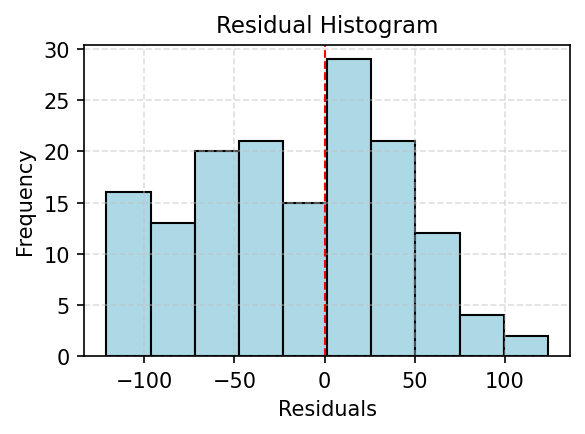

In [ ]:
# Assuming 'model' and 'test_features' are defined from the previous code
residuals = scaler.inverse_transform(labels) - scaler.inverse_transform(model.predict(features_set))

plt.figure(figsize=(4, 3))
plt.hist(residuals, bins=10, color= 'lightblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.tight_layout()

plt.savefig('Figure_residuals_LSTM.svg')
plt.savefig('Figure_residuals_LSTM.png', dpi=600)
plt.show()


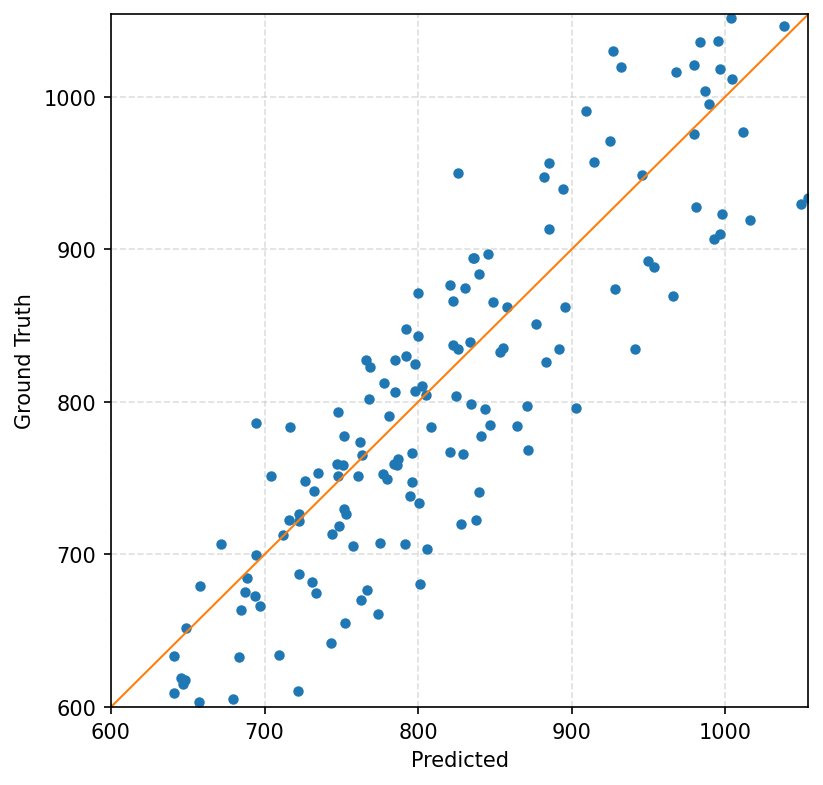

In [ ]:
# plot Q-Q plot
plt.figure(figsize=(6,6))
plt.plot(Train.Previsao, Train.Train, 'o')
plt.plot([min(Train.Previsao.min(), Train.Train.min()), max(Train.Previsao.max(), Train.Train.max())],
        [min(Train.Previsao.min(), Train.Train.min()), max(Train.Previsao.max(), Train.Train.max())])
plt.xlim(600, max(Train.Previsao))
plt.ylim(600, max(Train.Previsao))

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.show()



# Evaluate results on test data

In [ ]:
#previsão utilizando o modelo gerado
previsao = model.predict(test_features)
previsao = scaler.inverse_transform(previsao).ravel()

test_labels_1d = scaler.inverse_transform(test_labels)
test_labels_1d = test_labels_1d.reshape(-1)

result = pd.DataFrame({'Test': test_labels_1d , 'Previsao': previsao}, index=df[-test_size:].index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Train MAPE: 6.03%
Train RMSE: 57.33
Test_MAPE: 5.49%
TestRMSE: 65.74


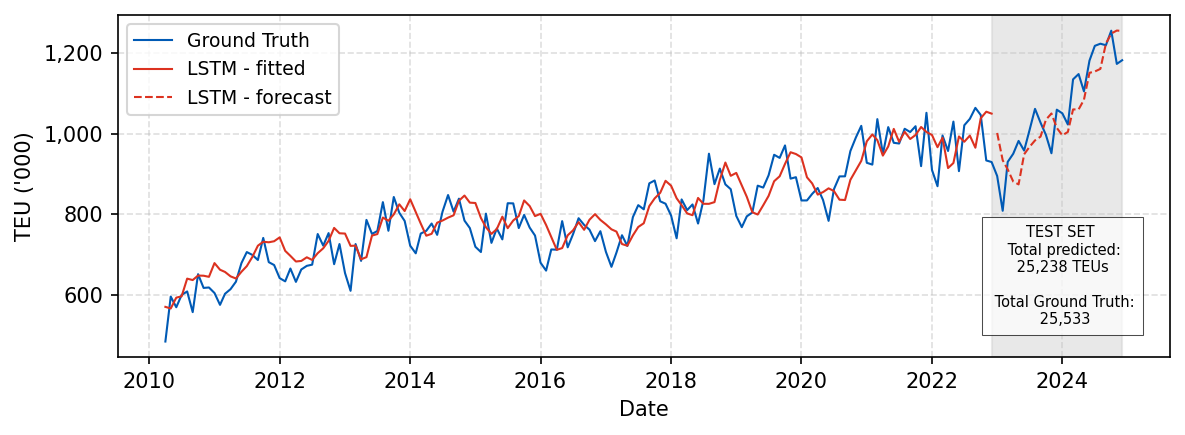

In [ ]:
scores = scoring(test_features, test_labels, model)

test_mape = scores[0]
test_rmse = scores[1]

print(f'Train MAPE: {train_mape:.2f}%')
print(f'Train RMSE: {train_rmse:.2f}')

print(f'Test_MAPE: {test_mape:.2f}%')
print(f'TestRMSE: {test_rmse:.2f}')

prediction_series = np.append(Train.Previsao.values, result.Previsao.values)

Real_test = result.Test.sum()
Predicted_test = result.Previsao.sum()

#####################################################################3
plt.figure(figsize=(8,3))

sns.lineplot(x= df.index[3:], y= df.TEU[3:] , label='Ground Truth', color= blue)
sns.lineplot(x= Train.index, y= Train.Previsao, label='LSTM - fitted', color= red)
sns.lineplot(x= result.index, y= result.Previsao, label='LSTM - forecast' ,linestyle = '--', color= red)

plt.axvspan(Train.index[-1], result.index[-1], color='lightgrey', alpha=0.5)

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(fontsize=9)

#plt.title("LSTM - Test - MAPE: {0:.2f}%".format(test_mape))
plt.xlabel('Date')
plt.ylabel("TEU ('000)")

plt.text(result.index[int(round(result.shape[0]/2 , 0 ))], result.Test.min()*0.8,
         'TEST SET \n Total predicted:\n {:,.0f} TEUs \n\n Total Ground Truth:\n {:,.0f}'.format(Predicted_test, Real_test),
         fontsize=7,
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center')

plt.tight_layout()

plt.savefig('Figure_LSTM.svg')
plt.savefig('Figure_LSTM.png', dpi=600)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


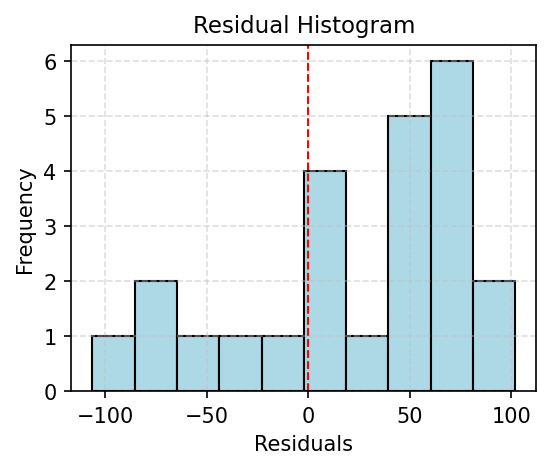

In [ ]:
# Assuming 'model' and 'test_features' are defined from the previous code
residuals_test = scaler.inverse_transform(test_labels) - scaler.inverse_transform(model.predict(test_features))

plt.figure(figsize=(4, 3))
plt.hist(residuals_test, bins=10, color= 'lightblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()